<a href="https://colab.research.google.com/github/mingyucai/LQR_CBF_rrtStar/blob/main/LQR_car_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# continuous LQR: https://github.com/stephentu/zero-to-cartpole/blob/master/swing-up.ipynb

# iLQR: https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/
# iLQR paper: https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf  implementation: https://github.com/anassinator/ilqr

In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    
    return -K

def lqr(A,B,Q,R):
  X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
  #compute the LQR gain
  K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

  eigVals, eigVecs = scipy.linalg.eig(A-B*K)

  return -K

In [2]:
def getB(yaw, dt):
  B = np.matrix([[np.cos(yaw) * dt, 0], [np.sin(yaw) * dt, 0], [0, dt]])
  return B

A = np.matrix([[1.0, 0, 0],[0 , 1.0, 0], [0, 0, 1.0]])
Q = np.matrix("0.5 0 0; 0 1 0; 0 0 1")
R = np.matrix("0.01 0; 0 0.01")

# print(xk[2, 0])
# print(R)
xd = np.matrix([[10], [20], [np.pi/2]])
xk = np.matrix([[0], [0], [0]])
print(xk.shape)
dt = 0.1
yaw = xk[2, 0]
B= getB(yaw, dt)

# Optional Variables
max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second
# xe = xk - xd
# K = dlqr(A,B,Q,R)
# uk = K*xe
# print(uk)z
# print(uk)

(3, 1)


In [3]:
K = dlqr(A,B,Q,R)
print(K)

LinAlgError: ignored

In [5]:
def dLQR(A, B, Q, R):
    """
    Discrete-time linear quadratic regulator for a nonlinear system.
 
    Compute the optimal control inputs given a nonlinear system, cost matrices, 
    current state, and a final state.
     
    Compute the control variables that minimize the cumulative cost.
 
    Solve for P using the dynamic programming method.
 
    :param actual_state_x: The current state of the system 
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]
    :param desired_state_xf: The desired state of the system
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]   
    :param Q: The state cost matrix
        3x3 NumPy Array
    :param R: The input cost matrix
        2x2 NumPy Array
    :param dt: The size of the timestep in seconds -> float
 
    :return: u_star: Optimal action u for the current state 
        2x1 NumPy Array given the control input vector is
        [linear velocity of the car, angular velocity of the car]
        [meters per second, radians per second]
    """
 

    N = 50
 
    # Create a list of N + 1 elements
    P = [None] * (N + 1)
     
    Qf = Q
 
    # LQR via Dynamic Programming
    P[N] = Qf
 
    # For i = N, ..., 1
    for i in range(N, 0, -1):
 
        # Discrete-time Algebraic Riccati equation to calculate the optimal 
        # state cost matrix
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)   

        # print(P[i-1])   

    
    # Create a list of N elements
    K = [None] * N
    u = [None] * N

    P1 = P[N-1]
    # K1 = np.matrix(scipy.linalg.inv(B.T*P1*B+R)*(B.T*P1*A))
    # print('inner', K1)

    # print('solution', B.T @ P[N] @ B + R)
    # print("K", -np.linalg.inv(R + B.T @ P[N] @ B) @ B.T @ P[N] @ A)
    # # For i = 0, ..., N - 1
    # for i in range(N):
 
    #     # Calculate the optimal feedback gain K
    #     print(B.T @ P[i+1] @ B + R)
    #     K[i] = -np.linalg.inv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A

    K1 = -np.linalg.inv(R + B.T @ P[N] @ B) @ B.T @ P[N] @ A
    

    return K1#K[N-1]

In [6]:
K = dLQR(A,B,Q,R)
print(K)

[[-3.33333333  0.          0.        ]
 [ 0.          0.         -5.        ]]


error 0.4233549451359764


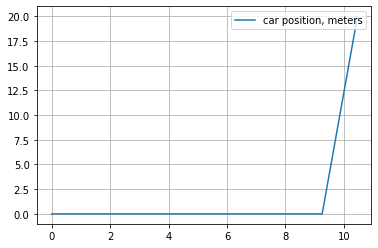

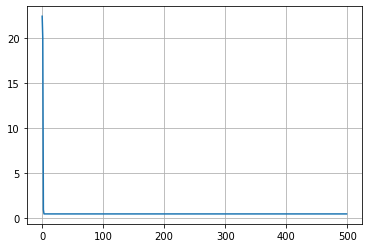

In [8]:
nsteps = 500
time = np.linspace(0, 2, nsteps, endpoint=True)
xd = np.matrix([[10], [20], [np.pi/2]])
xk = np.matrix([[0], [0], [0]])
dt = 0.5

X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    errors.append( np.linalg.norm(xe))

    yaw = xk[2, 0]
    B= getB(yaw, dt) 
    K = dLQR(A,B,Q,R)

    uk = K*xe
    X.append(xk[0, 0])
    Y.append(xk[1, 0])

    xk = A*xk + B*uk

print('error', np.linalg.norm(xe))

plt.plot(X, Y, label="car position, meters")
# plt.plot(time, T, label='pendulum angle, radians')
# plt.plot(time, U, label='control voltage, decavolts')

plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(errors, label="error")
plt.grid()
plt.show()

In [10]:
# linear dynnamics

dt = 0.05

A = np.matrix([[1, 0],[0 , 1]])
B = np.matrix([[dt, 0], [0, dt]])

Q = np.matrix("1 0; 0 1")
R = np.matrix("0.01 0; 0 0.01")

Q = np.matrix("1 0; 0 1")
R = np.matrix("0.01 0; 0 0.01")
K = dlqr(A,B,Q,R)

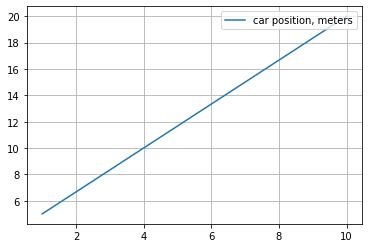

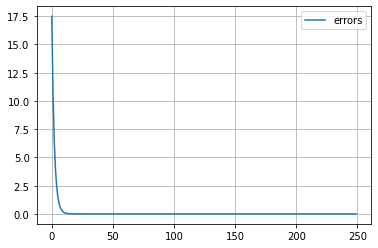

In [13]:
nsteps = 250
time = np.linspace(0, 2, nsteps, endpoint=True)
xk = np.matrix("10; 20")
xd = xd = np.matrix("1; 5")

X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    uk = K*xe
    X.append(xk[0, 0])
    Y.append(xk[1, 0])
    errors.append( np.linalg.norm(xe))

    xk = A*xk + B*uk

plt.plot(X, Y, label="car position, meters")
plt.legend(loc='upper right')
plt.grid()
plt.show()


plt.plot(errors, label="errors")
plt.legend(loc='upper right')
plt.grid()
plt.show()